In [8]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import breathDetectionFunctions as bd   
% matplotlib inline

#breathDetection_v1.2

#This breath detection model tries to detect the filling and emptying of the users lungs based on whether the chest sensor is extended more than or less than moving average at a given time.
 

#New this version: 
#- went back to calculating 30s average breath rate

#- Basic rejection algorithm discards breath times shorter than 1.5s and longer than 16s from the calculation of the breath rate. This filter is implemented throug hthe "filterBreaths" function.

#- plotting average of rise and fall breath rate as well (rfmav)

In [9]:
# read in dataset Jill
dset = pd.read_csv('JavierSalcedo1.txt',sep = ' ') # read in dataset
#dset.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
#dset['time'] = dset.index*(1/20) # add timestamp assuming 20 samples / second
#print(dset.head(5))
print(dset.shape[0])
print(dset.shape[0]/600)

9575
15.958333333333334


In [10]:
# pick subsample (just for visualization purposes, so I am not plotting the whole dataset each time.)
d = pd.DataFrame(data = dset[0:dset.shape[0]]) # select which data points; used to be [:8000]
#d = pd.DataFrame(data = dset[0:25000]) # select which data points; used to be [:8000]
d.index = pd.RangeIndex(start = 0, stop = len(d), step = 1) # to measure time from beginning of sub-sample
d.columns = ['chest','belly','ax','ay','az','gx','gy','gz']
d['time'] = d.index*(1/10) # add timestamp assuming 10 samples / second
#print(d.head(5))

d = d.reset_index()

# smoothen sample: subsecond dynamics are removed using exponentially weighted moving average
d['cesm'] = d['chest'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen
d['besm'] = d['belly'].rolling(window = 100,center = False).apply(lambda x: bd.expSmoothen(x,20)) # smoothen

# calculate [6] second moving average and subtract it from smoothened signal to remove long-term drift 
d['cmav'] = d['chest'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['del'] = d['cesm'] - d['cmav']

d['bmav'] = d['belly'].rolling(window = 7*20,center = False).mean() - 0 # slight offset because breaths are held for some time.
d['bdel'] = d['besm'] - d['bmav']

# identify breath phase: distinguishes between above-average and below-average expansion of the sensor. 
d['ph1'] = d['del'].apply(bd.phase) # function: +1 if positive, -1 if negative
d['ph2'] = d['bdel'].apply(bd.phase) # function: +1 if positive, -1 if negative

# take derivative of phase curve: +1 where rise, -1 where fall
d['ph1_slp'] = 0.025*d['ph1'].rolling(window = 2, center = False).apply(bd.slp)
d['ph2_slp'] = 0.025*d['ph2'].rolling(window = 2, center = False).apply(bd.slp)

# store vector with the last [-x:] rise times,
d['riseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]>0].values[-10:])
d['briseTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]>0].values[-10:])

# store vector with the last [-x:] fall times
d['fallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph1_slp'][0:int(x/(1/20))]<0].values[-10:])
d['bfallTimes'] = d['time'].apply(lambda x: d['time'][0:int(x/(1/20))][d['ph2_slp'][0:int(x/(1/20))]<0].values[-10:])

# calculate last [19] breath times based on rise times
d['rbtime'] = d['riseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['fbtime'] = d['fallTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on rise times
d['brbtime'] = d['briseTimes'].apply(lambda x: x[1:] - x[:-1])
# calculate last [19] breath times based on fall times
d['bfbtime'] = d['bfallTimes'].apply(lambda x: x[1:] - x[:-1])

# replace empty entries with NaN
def repNan(x):
    if len(x) == 0:
        return [np.nan]
    else:
        return x
    
# filter all breath measurements that are unrealistically short or long
def filterBreaths(x):
    return [d for d in x if d > 1.5 and d < 24]
    
d['rbtime'] = d['rbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['fbtime'] = d['fbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['brbtime'] = d['brbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)
d['bfbtime'] = d['bfbtime'].apply(lambda x: filterBreaths(x)).apply(repNan)

#def lastEntry(x):
#    if len(x) > 0:
#        return x[-1]
#    else:
#        return np.nan
    
d['rlast'] = d['rbtime'].apply(lambda x: x[-1])
d['flast'] = d['fbtime'].apply(lambda x: x[-1])
d['brlast'] = d['brbtime'].apply(lambda x: x[-1])
d['bflast'] = d['bfbtime'].apply(lambda x: x[-1])

# calculate averaged breath time 
d['rmav'] = d['rlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['fmav'] = d['flast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['rfmav'] = (d['rmav']+ d['fmav'])/2

d['brmav'] = d['brlast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x)
d['bfmav'] = d['bflast'].rolling(window = 30*20, center = False).mean().apply(lambda x: 60/x) # calculate 30s average breath rate
d['brfmav'] = (d['brmav']+ d['bfmav'])/2

#Breathing rate averages Chest and Belly
d['cbrfmav'] = d['brfmav']*0.1+d['rfmav']*0.9

# movement data acceleration
d['acc'] = d['ax'].multiply(d['ax']) + d['ay'].multiply(d['ay']) + d['az'].multiply(d['az'])

# movement data angular velocity
d['gyr'] = d['gx'].multiply(d['gx']) + d['gy'].multiply(d['gy']) + d['gz'].multiply(d['gz'])

In [11]:
f = d

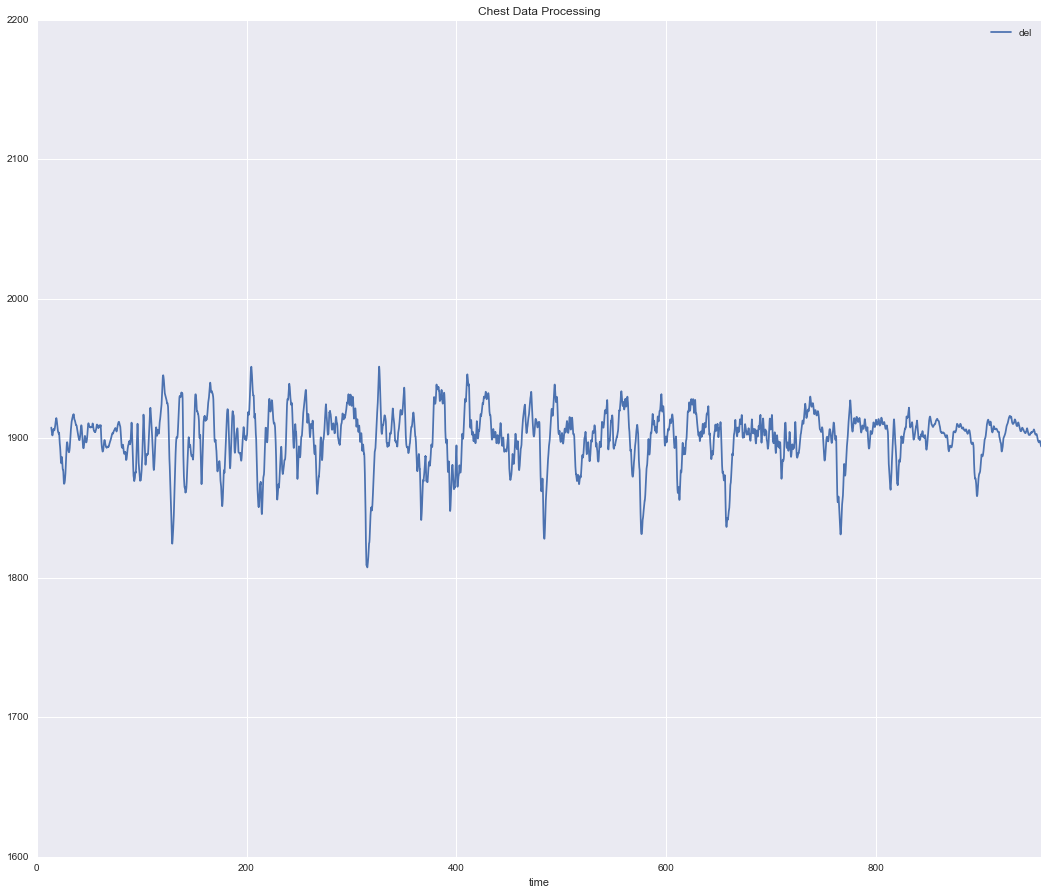

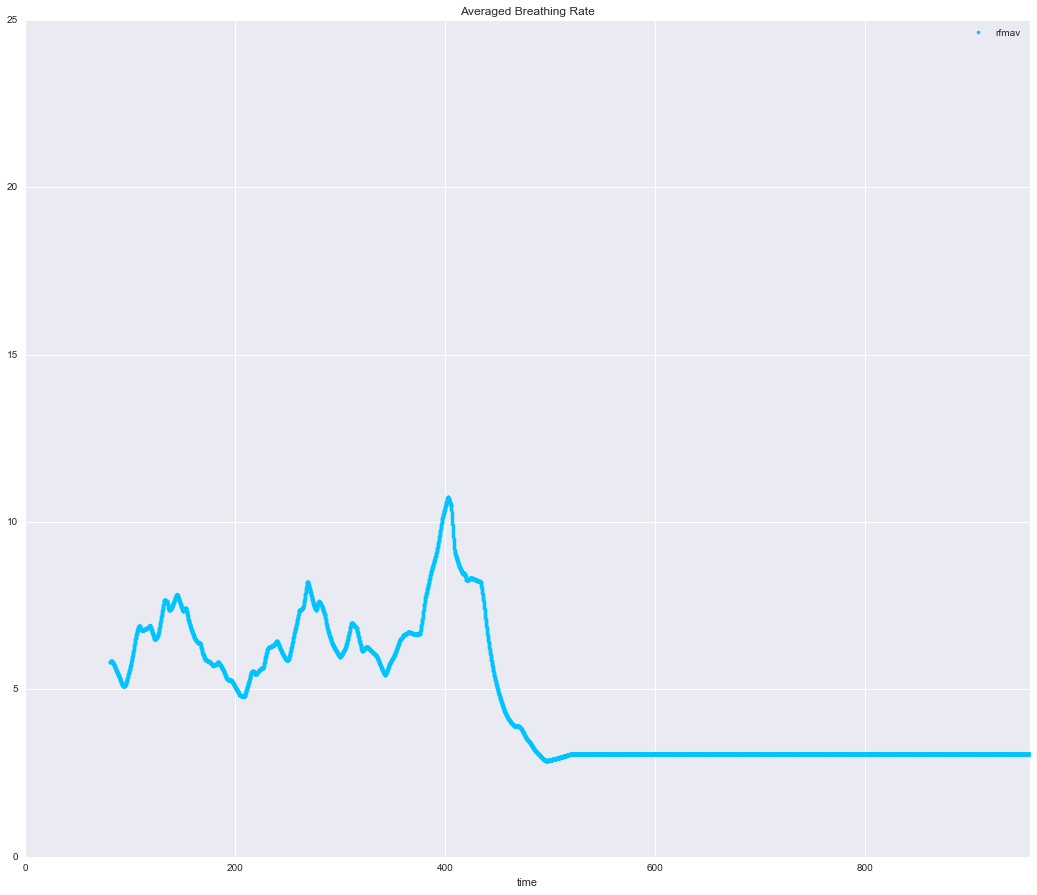

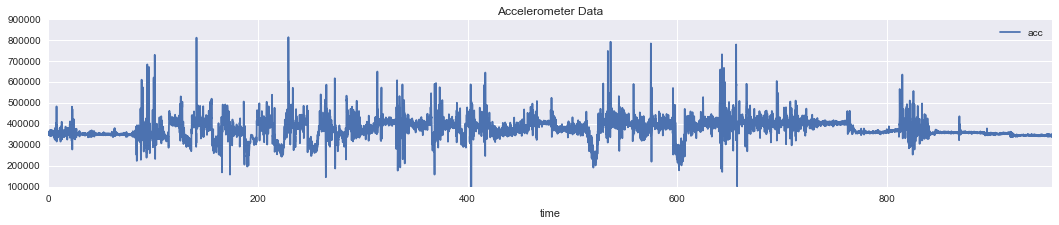

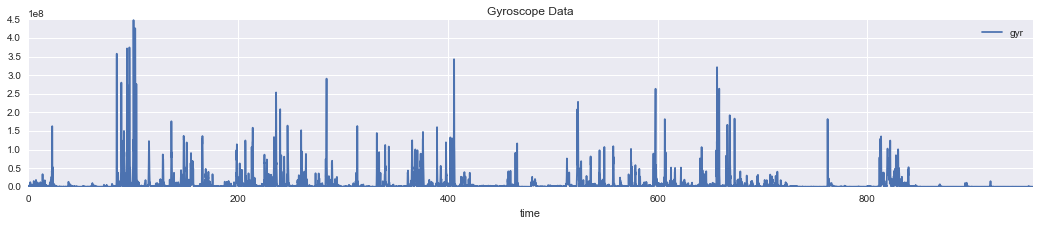

In [12]:
# this is just for plotting data 
g = f
g['cesm'] = f['cesm'] - 500
g['cmav'] = f['cmav'] - 500
g['del'] = f['del'] + 1900
g['b1'] = 1900
g['ph1'] = 100*f['ph1'] + 2800
g['b2'] = 1600
g['ph2'] = 100*f['ph2'] + 2200
#g.plot(x = 'time',y = ['chest','belly','cesm','cmav','del','b1','ph1','b2'],figsize = (18,15),title = 'Chest Data Processing')
g.plot(style=['-'],x = 'time',y = ['del'],figsize = (18,15), ylim = (1600,2200), title = 'Chest Data Processing')
#g.plot(x = 'time',y = ['chest','belly','ph1','ph2'],figsize = (18,15),title = 'Breathing Raw Data')
#d.plot(x = 'time',y = ['rlast','flast'], figsize = (18,3), title = 'Length of last detected breath, based on successive rise (r) and fall (f) times.')
d.plot(style=['.'], x = 'time',y = ['rfmav'], color = '#00C4FF', ylim = (0,25), figsize = (18,15), title = 'Averaged Breathing Rate')
d.plot(x = 'time',y = 'acc',figsize = (18,3),title = 'Accelerometer Data')
d.plot(x = 'time',y = 'gyr',figsize = (18,3),title = 'Gyroscope Data')

Note that all moving averages are calculated using only data available at the time, which causes the corresponding curves to lag behind (compare moving averages of breath times to real-time breath times above). 

In [13]:
print(d[::1000]) # every thousandth line of the processed dataset

      index  chest  belly   ax   ay   az     gx    gy   gz   time  ...   \
0         0   3122   3046   14  524  286     58  -264 -599    0.0  ...    
1000   1000   3140   3081 -232  359  435 -11175  -578 -882  100.0  ...    
2000   2000   3129   2994   28 -194  636  -2004 -1250 -324  200.0  ...    
3000   3000   3194   3030    9 -532  295   -100  -605  -32  300.0  ...    
4000   4000   3150   3033   24 -116  649  -2425  -736  -43  400.0  ...    
5000   5000   3186   2977   20 -519  403    -31  -694 -287  500.0  ...    
6000   6000   3135   2937  462  124  -18   1414  -879 -945  600.0  ...    
7000   7000   3176   2932   23 -359  515     24  -435  -46  700.0  ...    
8000   8000   3181   3105    3  486  363     74 -1441 -340  800.0  ...    
9000   9000   3179   3055   25  511  307    -38  -655   73  900.0  ...    

           fmav      rfmav     brmav     bfmav    brfmav    cbrfmav     acc  \
0           NaN        NaN       NaN       NaN       NaN        NaN  356568   
1000   5.684779 

In [14]:
d.head(6000)

,index,chest,belly,ax,ay,az,gx,gy,gz,time,...,fmav,rfmav,brmav,bfmav,brfmav,cbrfmav,acc,gyr,b1,b2
0,0,3122,3046,14,524,286,58,-264,-599,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,356568,431861,1900,1600
1,1,3121,3055,17,526,291,621,-582,-206,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,361646,766801,1900,1600
2,2,3106,3057,9,524,268,382,-795,28,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,346481,778733,1900,1600
3,3,3101,3060,15,527,272,-525,-1084,-293,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,351938,1536530,1900,1600
4,4,3111,3063,15,524,273,-675,-930,143,0.4,...,NaN,NaN,NaN,NaN,NaN,NaN,349330,1340974,1900,1600
5,5,3122,3062,17,531,279,-1093,-1388,-217,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,360091,3168282,1900,1600
6,6,3130,3057,16,505,307,-1135,-739,26,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,349530,1835022,1900,1600
7,7,3136,3060,19,511,296,-841,406,678,0.7,...,NaN,NaN,NaN,NaN,NaN,NaN,349098,1331801,1900,1600
8,8,3141,3060,16,507,304,-271,683,596,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,349721,895146,1900,1600
9,9,3143,3064,23,511,303,120,774,422,0.9,...,NaN,NaN,NaN,NaN,NaN,NaN,353459,791560,1900,1600
